## HuBMAP HPA data converter

In [1]:
# Mount your Google Drive. You can permanently mount yours if you've allowed "Mount Drive" on Files section (left panel)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ~/ : root/
#!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/DeepLearning/HubMAP/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c hubmap-organ-segmentation
!unzip /content/hubmap-organ-segmentation.zip -d /content/hubmap-organ-segmentation
!rm /content/hubmap-organ-segmentation.zip

In [4]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 445 kB/s 


##Basic concept idea of resizing data is:

  - (img_size + padding) / (tile_size * resize_ratio) = # of patches
      - Adding padding makes (img_size + padding) % (tile size * resize_ratio) = 0

  - Patch.resize(tile_size, interpolation=inter_area)
      - Resize_ratio determines the patch area. If resize_ratio = 3, for example, then the area is 9 (width * height in a patch). So the resized patch (=tile size) is 9 times smaller and less precise than the original patch (=tile_size * resize_ratio)

In [5]:
import gc
import os
import cv2
import zipfile
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
import random
import math
from PIL import Image
from tqdm.notebook import tqdm
from rasterio.windows import Window
from torch.utils.data import Dataset

TRAIN_IMG = 'train_img.zip'
TRAIN_MASK = 'train_mask.zip'
TILE_SIZE = 256 # tile size 
RESIZE_RATIO = 4 # if 4, then divide 
IMGS = '/content/hubmap-organ-segmentation/train_images'
RLE = '/content/hubmap-organ-segmentation/train.csv'

In [6]:
# functions to convert encoding to mask and vice versa
def enc2mask(encs, shape):
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    # For this code, i is meaningless. But I keep it for later use for multiclass encs
    for i, enc in enumerate(encs):
        if isinstance(enc, float) and np.isnan(enc): 
            continue
        rle_list = enc.split()
        for j in range(len(rle_list)//2):
            start = int(rle_list[2*j]) - 1
            length = int(rle_list[2*j+1])
            img[start:start+length] = 1 + i # i for multi-class encs
    return img.reshape(shape).T

def mask2enc(mask, n=1):
    pixels = mask.T.flatten()
    encs = []
    for i in range(1, n+1):
        p = (pixels == i).astype(np.uint8)
        if p.sum() == 0:
            encs.append(np.nan)
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])
            runs[1::2] -= runs[::2]
            encs.append(' '.join(map(str, runs)))
            #encs.append(' '.join(str(x) for x in runs)) 

df_rle = pd.read_csv(RLE)[['id', 'rle']].set_index('id')
print(df_rle.head())

                                                     rle
id                                                      
10044  1459676 77 1462675 82 1465674 87 1468673 92 14...
10274  715707 2 718705 8 721703 11 724701 18 727692 3...
10392  1228631 20 1231629 24 1234624 40 1237623 47 12...
10488  3446519 15 3449517 17 3452514 20 3455510 24 34...
10610  478925 68 481909 87 484893 105 487863 154 4908...


In [7]:
# one of the new images cannot be loaded into 16GB RAM
# use rasterio to load image part by part

sat_th = 40 # saturation threshold
pixel_th = 1000 * (TILE_SIZE // 256) ** 2 # minimum # of pixels

class HuBMAPDataset(Dataset):
      def __init__(self, idx, tile_size=TILE_SIZE, ratio=RESIZE_RATIO, encs=None):
          self.data = rasterio.open(os.path.join(IMGS, str(idx) + '.tiff'), num_threads='all_cpus')
          # type(self.data): <class 'rasterio.io.DatasetReader'>
          # self.data: <open DatasetReader name='/content/hubmap-organ-segmentation/train_images/10044.tiff' mode='r'>

          # self.data.count: # of raster bands
          if self.data.count != 3:
              subdatasets = self.data.subdatasets
              self.layers = []
              if len(subdatasets) > 0:
                  for i, subdataset in enumerate(subdatasets):
                      self.layers.append(rasterio.open(subdataset))
          self.shape = self.data.shape
          self.ratio = ratio
          self.patch = tile_size * ratio
          self.pad0 = (self.patch - self.shape[0] % self.patch) % self.patch
          self.pad1 = (self.patch - self.shape[1] % self.patch) % self.patch
          self.patch_n0 = (self.shape[0] + self.pad0) // self.patch # maximum # of patches in height of image
          self.patch_n1 = (self.shape[1] + self.pad1) // self.patch # maximum # of patches in width of image
          self.mask = enc2mask(encs, (self.shape[1], self.shape[0])) if encs is not None else None

      def __len__(self):
          return self.patch_n0 * self.patch_n1

      def __getitem__(self, idx):
          # n0, n1: index of the patch          
          n0, n1 = idx//self.patch_n0, idx%self.patch_n1
          # x0, y0: coordinates of the top left corner of the patch in the image
          x0, y0 = -self.pad0//2 + n0 * self.patch, -self.pad1//2 + n1 * self.patch 

          # patch coordinates to copy image data, so p00,p10 >= 0, p01,p11 <= image height, image width
          p00, p01 = max(0, x0), min(x0 + self.patch, self.shape[0])
          p10, p11 = max(0, y0), min(y0 + self.patch, self.shape[1])
          img_padded = np.zeros((self.patch, self.patch, 3), np.uint8)
          mask_padded = np.zeros((self.patch, self.patch), np.uint8)

          if self.data.count == 3:
              img_padded[(p00-x0):(p01-x0), (p10-y0):(p11-y0)] = np.moveaxis(self.data.read([1,2,3], 
                                                                           window=Window.from_slices((p00,p01), (p10,p11))), 0, -1)
          else:
              for i, layer in enumerate(self.layers):
                  img_padded[(p00-x0):(p01-x0),(p10-y0):(p11-y0),i] = layer.read(1,window=Window.from_slices((p00,p01),(p10,p11)))
          if self.mask is not None:
              mask_padded[(p00-x0):(p01-x0),(p10-y0):(p11-y0)] = self.mask[p00:p01, p10:p11]

          if self.ratio != 1:
              img_padded = cv2.resize(img_padded,(self.patch//self.ratio,self.patch//self.ratio),interpolation =cv2.INTER_AREA)
              mask_padded = cv2.resize(mask_padded,(self.patch//self.ratio,self.patch//self.ratio),interpolation=cv2.INTER_NEAREST)
          
          # check for empty images
          hsv = cv2.cvtColor(img_padded, cv2.COLOR_BGR2HSV)
          h, s, v = cv2.split(hsv)

          #return img_padded, mask_padded, (-1 if(s>sat_th).sum()<=pixel_th or img_padded.sum()<=pixel_th else idx) # Less information than threshold, drop
          return img_padded, mask_padded, idx # Don't discard any info

x_tot,x2_tot = [],[]
with zipfile.ZipFile(TRAIN_IMG,'w') as img_out, zipfile.ZipFile(TRAIN_MASK,'w') as mask_out:
      for index, encs in tqdm(df_rle.iterrows(), total=len(df_rle)):
          dataset = HuBMAPDataset(idx=index, encs=encs)
          for i in range(len(dataset)):
              img, mask, idx = dataset[i]
              if idx < 0:
                  continue
              x_tot.append((img/255.0).reshape(-1,3).mean(axis=0))
              x2_tot.append(((img/255.0)**2).reshape(-1,3).mean(axis=0))
              img = cv2.imencode('.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))[1]
              img_out.writestr(f'{index}_{idx:04d}.png', img)
              mask = cv2.imencode('.png', mask)[1]
              mask_out.writestr(f'{index}_{idx:04d}.png', mask)

#image stats
img_avr = np.array(x_tot).mean(axis=0)
img_std = np.sqrt(np.array(x2_tot).mean(axis=0)- img_avr**2)
print('mean:', img_avr, ', std:', img_std)

  0%|          | 0/351 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


mean: [0.78010093 0.7561739  0.77305921] , std: [0.24972272 0.26321073 0.25903101]


In [8]:
def displayAll(fig, rows, cols, img, mask, fname, i):
    x = i//cols
    fig.add_subplot(rows, 2*cols, i+1+x*cols)
    plt.axis('off')
    plt.title(fname)
    plt.imshow(img) # vs plt.imshow(Image.fromarray(img))
    fig.add_subplot(rows, 2*cols, i+1+(x+1)*cols)
    plt.axis('off')
    plt.title(fname)
    plt.imshow(mask, alpha=0.7)

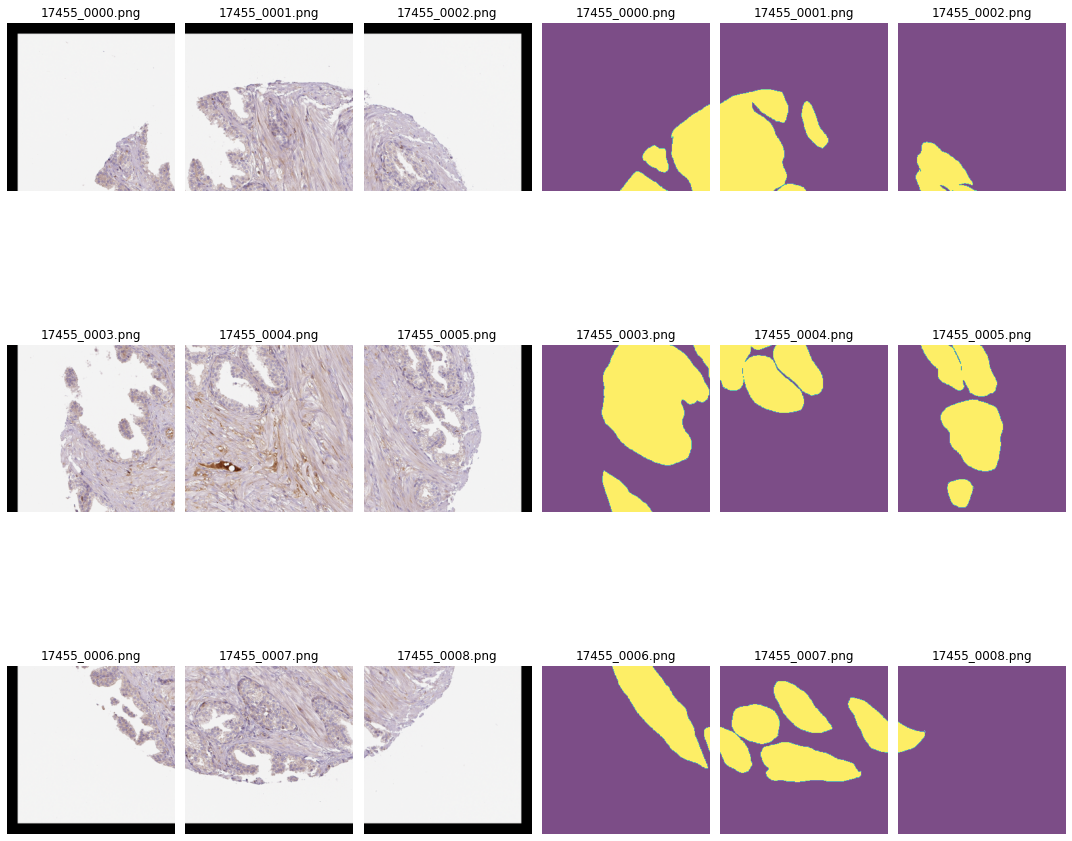

In [9]:
cols, rows = math.ceil(np.sqrt(len(dataset))), math.ceil(np.sqrt(len(dataset)))
fig = plt.figure(figsize=(15,15), tight_layout=True)
randomPick_indexList = []
with zipfile.ZipFile(TRAIN_IMG, 'r') as img_arch, zipfile.ZipFile(TRAIN_MASK, 'r') as mask_arch:
      fnames = sorted(img_arch.namelist())
      randomNumber = random.randint(0, len(fnames))
      randomPick = fnames[randomNumber].split('_')[0]
      #randomPick_indexList = [i for i, x in enumerate(fnames) if x.__contains__(randomPick + '_')] # [i for i, x in enumerate(fnames) if randomPick in x], or np.where))
      randomPick_indexList = [i for i, x in enumerate(fnames) if x.startswith(randomPick + '_')]
      for i, idx in enumerate(randomPick_indexList):
          img = cv2.imdecode(np.frombuffer(img_arch.read(fnames[idx]), np.uint8), cv2.IMREAD_COLOR)
          img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)          
          mask = cv2.imdecode(np.frombuffer(mask_arch.read(fnames[idx]), np.uint8), cv2.IMREAD_GRAYSCALE)                    
          displayAll(fig, rows, cols, img, mask, fnames[idx], i) # it won't work if you set to discard to less information
plt.show()